In [114]:
import os
import glob
import numpy as np
import xarray as xr
from scipy.ndimage import rotate

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
%matplotlib inline
import matplotlib
matplotlib.rcParams.update({'font.size':15})
import time
import cartopy.crs as ccrs
import cartopy
CMIP6_FOLDER = "/global/cfs/projectdirs/m3522/cmip6/"
SCRATCH="/global/cscratch1/sd/qnicolas/"

import sys
p = os.path.abspath('/global/homes/q/qnicolas/')
if p not in sys.path:
    sys.path.append(p)

from orographicPrecipitation.observationsAndERA5.mountainUtils import *

from scipy.stats import linregress
xr.set_options(display_style='text') 

# Functions, data loading

In [115]:
# Monthly data
orogm=xr.open_dataset(CMIP6_FOLDER+"ERA5/e5.oper.invariant/197901/e5.oper.invariant.128_129_z.ll025sc.1979010100_1979010100.nc").Z.isel(time=0)/9.81

gpm_pr_seasmean=xr.open_dataarray("/global/cscratch1/sd/qnicolas/temp/GPM-IMERG-seasonalmean-200101-202012.nc")

era5100u_seasmean=xr.open_dataarray("/global/cscratch1/sd/qnicolas/temp/e5.climatology.228_246_100u.2001-2020.nc")
era5100v_seasmean=xr.open_dataarray("/global/cscratch1/sd/qnicolas/temp/e5.climatology.228_247_100v.2001-2020.nc")

topo_hires = xr.open_dataset("/global/cscratch1/sd/qnicolas/ETOPO1_Ice_g_gmt4.grd").z.rename({'x':'longitude','y':'latitude'})
topo_hires = topo_hires.reindex(latitude=list(reversed(topo_hires.latitude)))
topo_hires.coords['longitude'] = topo_hires.coords['longitude'] % 360
topo_hires = topo_hires.sortby(topo_hires.longitude)

monthnames=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']


In [116]:
Ghats      = MountainRangeCustom("ghats"      ,[64,82,7,24]   ,"Western Ghats"           ,70 ,[6,7,8]  ,[ 75  ,   9  ,  71.5, 20   ,2  ])
Myanmar    = MountainRangeCustom("myanmar"    ,[84,102,7,24]  ,"Myanmar"                 ,60 ,[6,7,8]  ,[ 98  ,  11  ,  90  , 21   ,4  ])
Vietnam    = MountainRangeCustom("vietnam"    ,[100,118,8,25] ,"Annamite range (Vietnam)",240,[10,11]  ,[108  ,  18  , 111  , 13   ,2  ])
Malaysia   = MountainRangeCustom("malaysia"   ,[96,114,-2,15] ,"Malaysia"                ,225,[11,12]  ,[102.5,   8  , 105.5,  3   ,2  ])
Philippines= MountainRangeCustom("philippines",[117,135,5,22] ,"Philippines"             ,225,[11,12]  ,[123.5,  17  , 127  ,  9   ,2  ])
Newbritain = MountainRangeCustom("newbritain" ,[145,163,-17,0],"New Britain"             ,320,[6,7,8]  ,[154  , - 5.5, 150  , -8.5 ,2  ])

MRs = (Ghats,Myanmar,Vietnam,Malaysia,Philippines,Newbritain)


for MR in MRs:
    print(MR.name)
    MR.set_2dvar('GPM_PR',gpm_pr_seasmean)
    MR.set_2dvar('VAR_100U',era5100u_seasmean)
    MR.set_2dvar('VAR_100V',era5100v_seasmean)
    MR.set_2dvar('Z',orogm)
    MR.set_2dvar('Z_HR',np.maximum(topo_hires,0.))
    MR.set_3dvar('T',"128_130_t")
    MR.set_3dvar('Q',"128_133_q")
    MR.set_3dvar('U',"128_131_u")
    MR.set_3dvar('V',"128_132_v")
    MR.set_uperp()
    

ghats
myanmar
vietnam
malaysia
philippines
newbritain


In [117]:
for MR in MRs:
    print(MR.name)
    MR.set_daily_spavg_var('162_071_viwve','VIWVE','vinteg',where='upstream')
    MR.set_daily_spavg_var('162_072_viwvn','VIWVN','vinteg',where='upstream')
    MR.set_viwvperp_sfc()
    MR.set_daily_imerg()
    MR.set_daily_sfc_var('128_034_sstk','SST')
    MR.vars['UBL_DAILY'] = xr.open_dataarray("/global/cscratch1/sd/qnicolas/regionsDataBig/e5.diagnostic.uBL.2001-2020.{}.{}.nc".format(MR._monthstr,MR.name))
    MR.vars['VBL_DAILY'] = xr.open_dataarray("/global/cscratch1/sd/qnicolas/regionsDataBig/e5.diagnostic.vBL.2001-2020.{}.{}.nc".format(MR._monthstr,MR.name))
    MR.set_daily_Bl_vars('semi')
    
    for varname in 'SST','THETAEBSEMI','TLSEMI','QLSEMI','BLSEMI','GPM_PR':
        grid = MR.vars[varname+'_DAILY']
        MR.set_spatialmean(varname,'above',tilted_rect(grid,*MR.box_tilted,reverse=False),box=None)


ghats
myanmar
vietnam
malaysia
philippines
newbritain


In [118]:
for MR in MRs:
    print(MR.name)
    q_daily = xr.open_dataarray("/global/cscratch1/sd/qnicolas/regionsDataBig/e5.oper.an.pl.128_133_q.ll025sc.2001-2020.{}.{}.nc".format(MR._monthstr,MR.name))
    MR.vars['Q_VINTEG_DAILY'] = q_daily.integrate('level')

ghats
myanmar
vietnam
malaysia
philippines
newbritain


In [34]:
## Stability
#Newbritain.set_3dvar('PHI',"128_129_z")
#sample_geopotential = Newbritain.vars['PHI'].mean(['latitude','longitude'])/9.81
#dzdp = sample_geopotential.differentiate('level')
#
#for MR in MRs:
#    #dqdp = MR.vars['Q_UPSTREAM_DAILY'].differentiate('level')
#    #dqdz_K = 2.5e6/1004. * dqdp/dzdp
#    #dqdz_K = dqdz_K.sel(level=slice(700,900)).mean('level')
#    #MR.vars['DQDZ_UPSTREAM_DAILY'] = dqdz_K
#    t_daily = xr.open_dataarray("/global/cscratch1/sd/qnicolas/regionsDataBig/e5.oper.an.pl.128_130_t.ll025sc.2001-2020.{}.{}.nc".format(MR._monthstr,MR.name))
#    dTdp = t_daily.differentiate('level')
#    dsdz = dTdp/dzdp + 9.81/1004.
#    dsdz = dsdz.sel(level=slice(600,900)).mean('level')
#    MR.vars['DSDZ_DAILY'] = dsdz.load()

## Functions

In [15]:
from scipy.optimize import curve_fit
def fit(pred,dep,model='linear'):
    predrange = np.linspace(np.min(pred),np.max(pred),41)
    if model=='linear':
        func = lambda x,a,b : a*x+b
    elif model=='exponential':
        func = lambda x,a,b : np.exp(a*x+b)
    elif model=='softplus':
        func = lambda x,a,b : np.log(1+np.exp(a*x+b))
    popt,_ = curve_fit(func,pred,dep)
    fitrange = func(predrange,*popt)
    residual = dep - func(pred,*popt)
    rss = np.sum(residual**2)
    tss = len(dep)*np.var(dep)
    rsq = 1-rss/tss
    return predrange,fitrange,rsq

def get_bins(var,nbins):
    var_sorted = sorted(np.array(var).reshape(-1))
    quantiles=np.linspace(0.,len(var)-1,nbins+1)
    bins = [var_sorted[int(i)]  for i in quantiles]
    bin_centers = [np.mean(var_sorted[int(quantiles[i]):int(quantiles[i+1])]) for i in range(len(quantiles)-1)]
    return np.array(bins)#,np.array(bin_centers)

def select_bootstrap_sample(distribution):
    n=len(distribution)
    return distribution[np.random.randint(0,n,size=n)]
def bootstrap_CI_mean(data,CI_level,nsamples=10):
    """Compute a confidence interval for the mean of a et of data at the level CI_level (0<CI_level<100), using nsamples bootstrap samples"""
    means = np.array([select_bootstrap_sample(data).mean() for _ in range(nsamples)])
    return [np.percentile(means,50-CI_level/2),np.percentile(means,50+CI_level/2)]

def get_binned(a,b,bins,itq=False,bootstrap=False):
    idx_bin_inf = max(0,np.argmax(bins>float(a.min()))-1)
    idx_bin_sup = np.argmin(bins<float(a.max()))
    if idx_bin_sup==0 or idx_bin_sup==len(bins)-1:
        bins=bins[idx_bin_inf:]
    else:
        bins=bins[idx_bin_inf:idx_bin_sup+1]
    bin_centers=(bins[1:]+bins[:-1])/2
    digitized = np.digitize(np.array(a), bins)
    bin_means = np.array([np.array(b)[digitized == i].mean() for i in range(1, len(bins))])
    if itq:
        bin_median = np.array([np.median(np.array(b)[digitized == i]) for i in range(1, len(bins))])
        try:
            bin_q1 = np.array([np.quantile(np.array(b)[digitized == i],0.25) for i in range(1, len(bins))])
            bin_q2 = np.array([np.quantile(np.array(b)[digitized == i],0.75) for i in range(1, len(bins))])
        except IndexError:
            bin_q1 = bin_median
            bin_q2 = bin_median
        return bin_centers,bin_means,bin_median,bin_q1,bin_q2
    elif bootstrap :
        cinf_csup =  np.array([bootstrap_CI_mean(np.array(b)[digitized == i],95) for i in range(1, len(bins))])
        return bin_centers,bin_means,cinf_csup[:,0],cinf_csup[:,1]
    else:
        return bin_centers,bin_means
    
def get_count(a,bins):
    idx_bin_inf = max(0,np.argmax(bins>float(a.min()))-1)
    idx_bin_sup = np.argmin(bins<float(a.max()))
    if idx_bin_sup==0 or idx_bin_sup==len(bins)-1:
        bins=bins[idx_bin_inf:]
    else:
        bins=bins[idx_bin_inf:idx_bin_sup+1]
    bin_centers=(bins[1:]+bins[:-1])/2
    count = np.histogram(a,bins)[0]
    return bin_centers,count

In [16]:
from scipy import special
def linregress_xr_2(x,y,dim='time'):
    nt = len(x[dim])
    assert nt==len(y[dim])
    ssxm = nt*x.var(dim=dim)
    ssym = nt*y.var(dim=dim)
    ssxym = nt*xr.cov(x,y,dim=dim)       
    r = np.maximum(np.minimum(ssxym / np.sqrt(ssxm * ssym),1.),-1)
    slope = ssxym / ssxm
    
    df = nt - 2  # Number of degrees of freedom
    TINY = 1.0e-20
    t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
    
    pval = special.stdtr(df, -np.abs(t))*2 * x.isel({dim:0})**0
    
    return xr.merge([slope.rename('slope'),(r**2).rename('rsquared'),pval.rename('pvalue')])

def fdr(pvalues,alpha):
    sortidx = np.argsort(pvalues)
    psorted = pvalues[sortidx]
    psorted[np.isnan(psorted)]=1
    nval = len(pvalues)
    ifdr = np.argmax((psorted < alpha*np.arange(1,nval+1)/nval)[::-1])
    if ifdr == 0 and psorted[-1]>= alpha:
        ifdr=nval-1
    ifdr = nval - ifdr - 1
    return sortidx[:ifdr]

def fdr_xr_2d(pvalues,alpha):
    pvalues=np.array(pvalues)
    assert len(pvalues.shape)==2
    ntot = pvalues.shape[0]*pvalues.shape[1]
    idxs_1d = fdr(pvalues.reshape(-1),alpha)
    flags = np.zeros(ntot)
    flags[idxs_1d] = 1
    return flags.reshape(pvalues.shape)*pvalues**0

In [17]:
def add_wind(ax,u,v,color='k',width=0.001,scale=600,key=True,ref=100,app='/(m/s2)',pos=(0.87,1.03)):
    ax.coastlines()
    X = u.latitude.expand_dims({"longitude":u.longitude}).transpose()
    Y = v.longitude.expand_dims({"latitude":u.latitude})
    n=5
    m=5
    q=ax.quiver(np.array(Y)[::n,::m],np.array(X)[::n,::m], np.array(u)[::n,::m], np.array(v)[::n,::m], transform=ccrs.PlateCarree(),color=color,width=width,scale=scale)
    if key:
        ax.quiverkey(q, *pos, ref, label='%i m/s/K'%ref, labelpos='N', coordinates='axes',color='k',angle=0)
        
def add_latlon(ax,box):
    ax.set_anchor('W')
    dl=5
    lons=range(dl*(1+(int(box[0])-1)//dl),dl*(int(box[1])//dl)+1,dl)
    ax.set_xticks(lons)
    ax.set_xticklabels(lons)
    lats=range(dl*(1+(int(box[2])-1)//dl),dl*(int(box[3])//dl)+1,dl)
    ax.set_yticks(lats)
    ax.set_yticklabels(lats)
    ax.set_xlabel("")
    ax.set_ylabel("")
        

# Winds

In [45]:
import matplotlib.colors as colors
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [46]:
new_cmap = truncate_colormap(plt.cm.plasma,0.2,1)

Text(0.5, 0.98, 'Winds regressed onto $T_L$')

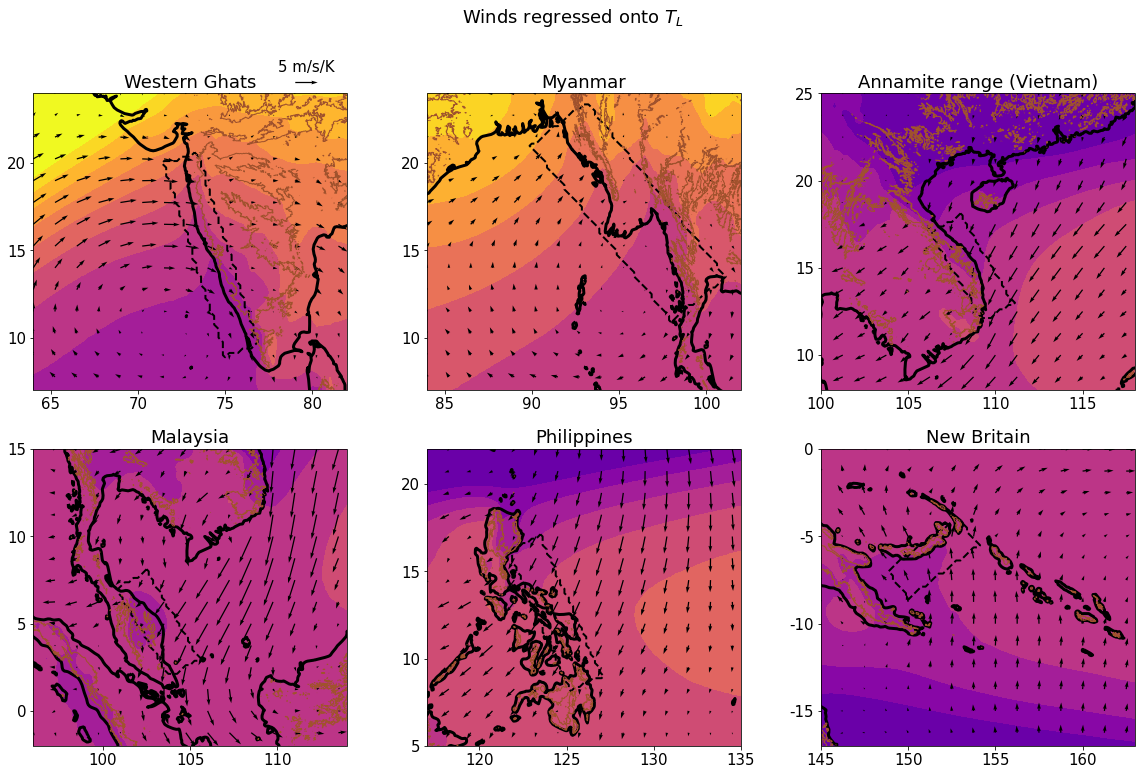

In [49]:
fig,axs = plt.subplots(2,3,figsize=(20,12),subplot_kw={"projection":ccrs.PlateCarree()})
axs=axs.reshape(-1)
predname = 'TL_DAILY'

levs = np.linspace(-60,60,21)
varname = 'UBL_DAILY'

for i,(ax,MR) in enumerate(zip(axs,MRs)):
    pred = -MR.vars['TLSEMI_ABOVE_DAILY']
    u = MR.vars['UBL_DAILY'];v = MR.vars['VBL_DAILY']
    
    MR.vars['TLSEMI_DAILY'].mean('time').plot.contourf(ax=ax,add_colorbar=False,levels=np.linspace(284,289,11),cmap=new_cmap)
    
    ureg = linregress_xr_2(pred,u)
    vreg = linregress_xr_2(pred,v)
    fdrfact = fdr_xr_2d(ureg.pvalue,0.1) + fdr_xr_2d(vreg.pvalue,0.1) >0
    u = ureg.slope /fdrfact;v=vreg.slope /fdrfact
    if i!=0:
        add_wind(ax,u,v,width=0.004,scale=70,key=False)
    else:
        add_wind(ax,u,v,width=0.004,scale=70,ref=5,pos=(0.87,1.04))
        
    #np.maximum(ureg.rsquared,vreg.rsquared).plot.contour(ax=ax,levels=[0.2,0.4],linewidths=[2,2],colors=['gold','red'])
    
    tilted_rect(ureg,*MR.box_tilted).plot.contour(ax=ax,levels=[0.5],linestyles=['--'],linewidths=[2],colors=['k'])
    sel_box(topo_hires,MR.box).plot.contour(ax=ax,transform=ccrs.PlateCarree(),levels=[500.],linewidths=[1],colors=['sienna'])
    
    ax.coastlines(linewidth=3)
    ax.set_title(MR.Lname)
    add_latlon(ax,MR.box)


/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


Text(0.5, 0.98, 'Winds regressed onto $\\Delta T_L$')

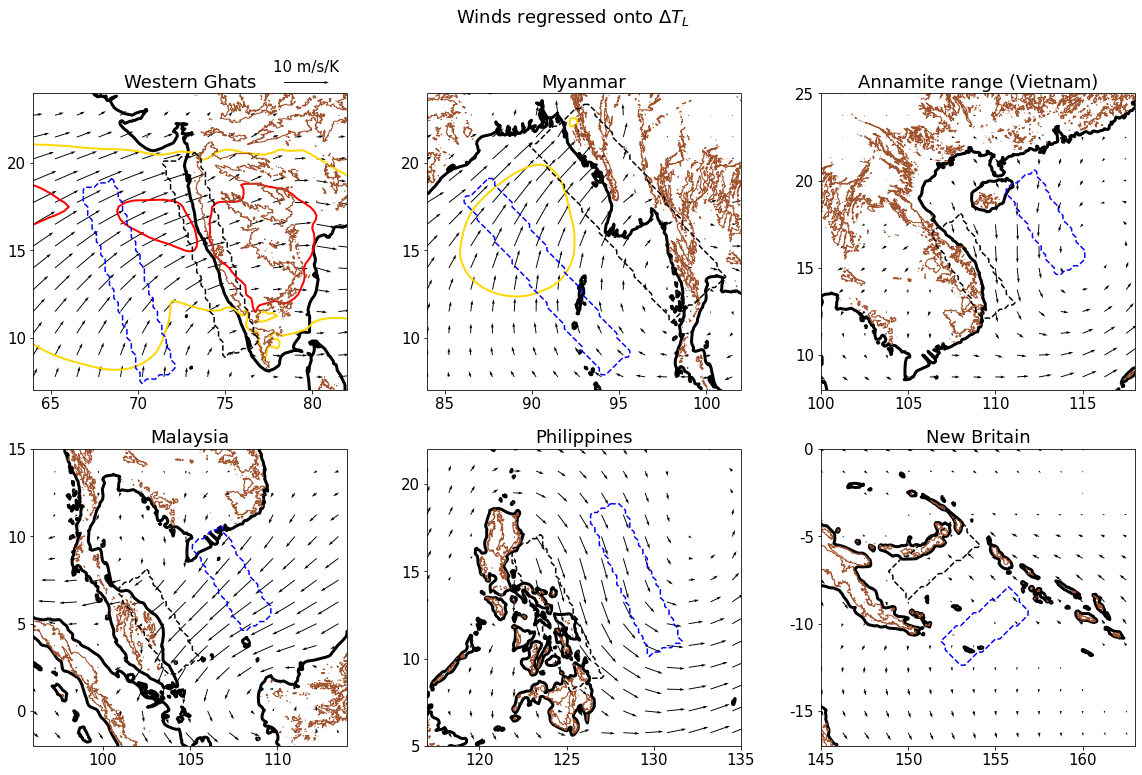

In [45]:
fig,axs = plt.subplots(2,3,figsize=(20,12),subplot_kw={"projection":ccrs.PlateCarree()})
axs=axs.reshape(-1)
predname = 'TL_DAILY'

levs = np.linspace(-60,60,21)
varname = 'UBL_DAILY'

for i,(ax,MR) in enumerate(zip(axs,MRs)):
    mask_ups = tilted_rect_distance(MR.vars['TLSEMI_DAILY'],*MR.box_tilted[:-1],-3,-5)
    pred = -MR.vars['TLSEMI_ABOVE_DAILY']+spatial_mean(MR.vars['TLSEMI_DAILY'],mask=mask_ups)
    u = MR.vars['UBL_DAILY'];v = MR.vars['VBL_DAILY']
    
    #mask_all = tilted_rect_distance(MR.vars['TLSEMI_DAILY'],*MR.box_tilted[:-1],2,-3)
    #t_ups = spatial_mean(MR.vars['TLSEMI_DAILY'],mask=mask_ups)
    #dsdz = spatial_mean(MR.vars['DSDZ_DAILY'],mask=mask_all)
    #pred = (-MR.vars['TLSEMI_ABOVE_DAILY']+t_ups)/dsdz*5e-3
    
    ureg = linregress_xr_2(pred,u)
    vreg = linregress_xr_2(pred,v)
    fdrfact = fdr_xr_2d(ureg.pvalue,0.1) + fdr_xr_2d(vreg.pvalue,0.1) >0
    u = ureg.slope /fdrfact;v=vreg.slope /fdrfact
    if i!=0:
        add_wind(ax,u,v,width=0.003,scale=70,key=False)
    else:
        add_wind(ax,u,v,width=0.003,scale=70,ref=10,pos=(0.87,1.04))
        

    np.maximum(ureg.rsquared,vreg.rsquared).plot.contour(ax=ax,levels=[0.2,0.4],linewidths=[2,2],colors=['gold','red'])
    sel_box(topo_hires,MR.box).plot.contour(ax=ax,transform=ccrs.PlateCarree(),levels=[500.],linewidths=[1],colors=['sienna'])
    
    tilted_rect(ureg,*MR.box_tilted).plot.contour(ax=ax,levels=[0.5],linestyles=['--'],colors=['k'])
    mask_ups.plot.contour(ax=ax,levels=[0.5],linestyles=['--'],colors=['b'])
    
    ax.coastlines(linewidth=3)
    ax.set_title(MR.Lname)
    add_latlon(ax,MR.box)

plt.suptitle(r'Winds regressed onto $\Delta T_L$')

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


Text(0.5, 0.98, 'Winds regressed onto $\\Delta T_L$')

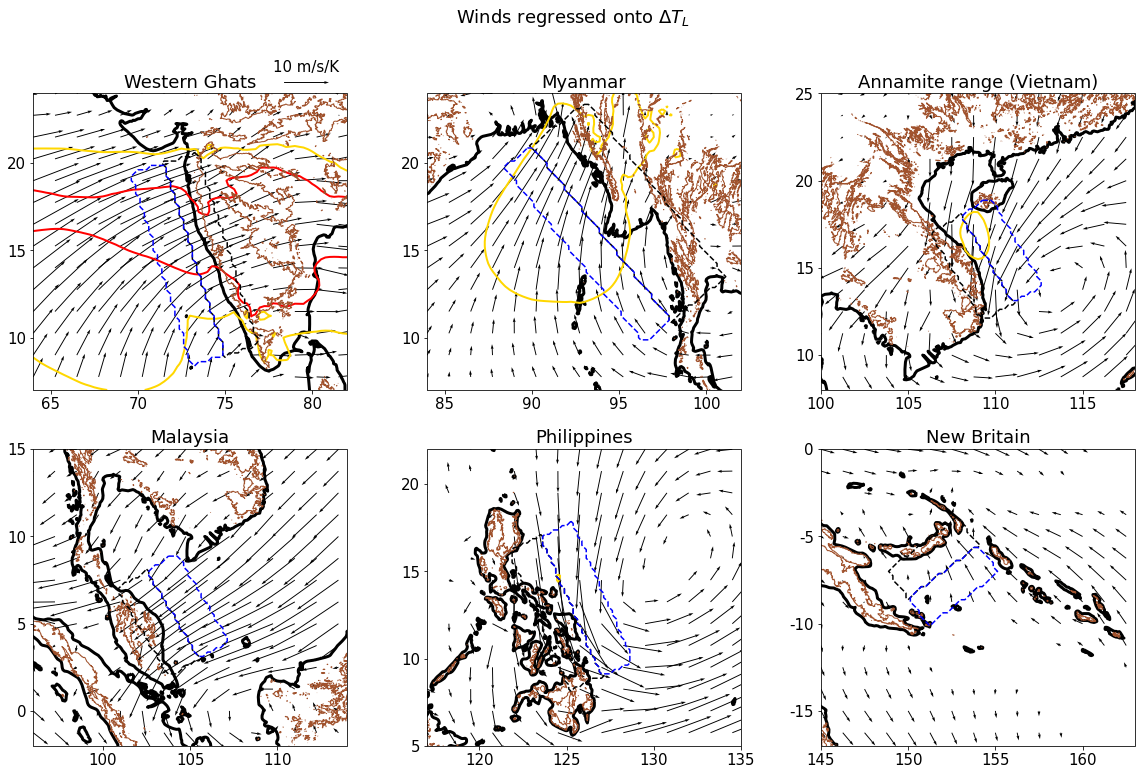

In [120]:
fig,axs = plt.subplots(2,3,figsize=(20,12),subplot_kw={"projection":ccrs.PlateCarree()})
axs=axs.reshape(-1)
predname = 'TL_DAILY'

levs = np.linspace(-60,60,21)
varname = 'UBL_DAILY'

for i,(ax,MR) in enumerate(zip(axs,MRs)):
    mask_ups = tilted_rect_distance(MR.vars['TLSEMI_DAILY'],*MR.box_tilted[:-1],0,-2)
    pred = -MR.vars['TLSEMI_ABOVE_DAILY']+spatial_mean(MR.vars['TLSEMI_DAILY'],mask=mask_ups)
    u = MR.vars['UBL_DAILY'];v = MR.vars['VBL_DAILY']
    
    #mask_all = tilted_rect_distance(MR.vars['TLSEMI_DAILY'],*MR.box_tilted[:-1],2,-3)
    #t_ups = spatial_mean(MR.vars['TLSEMI_DAILY'],mask=mask_ups)
    #dsdz = spatial_mean(MR.vars['DSDZ_DAILY'],mask=mask_all)
    #pred = (-MR.vars['TLSEMI_ABOVE_DAILY']+t_ups)/dsdz*5e-3
    
    ureg = linregress_xr_2(pred,u)
    vreg = linregress_xr_2(pred,v)
    fdrfact = fdr_xr_2d(ureg.pvalue,0.1) + fdr_xr_2d(vreg.pvalue,0.1) >0
    u = ureg.slope /fdrfact;v=vreg.slope /fdrfact
    if i!=0:
        add_wind(ax,u,v,width=0.003,scale=70,key=False)
    else:
        add_wind(ax,u,v,width=0.003,scale=70,ref=10,pos=(0.87,1.04))
        

    np.maximum(ureg.rsquared,vreg.rsquared).plot.contour(ax=ax,levels=[0.2,0.4],linewidths=[2,2],colors=['gold','red'])
    sel_box(topo_hires,MR.box).plot.contour(ax=ax,transform=ccrs.PlateCarree(),levels=[500.],linewidths=[1],colors=['sienna'])
    
    tilted_rect(ureg,*MR.box_tilted).plot.contour(ax=ax,levels=[0.5],linestyles=['--'],colors=['k'])
    mask_ups.plot.contour(ax=ax,levels=[0.5],linestyles=['--'],colors=['b'])
    
    ax.coastlines(linewidth=3)
    ax.set_title(MR.Lname)
    add_latlon(ax,MR.box)

plt.suptitle(r'Winds regressed onto $\Delta T_L$')

## Witch of Agnesi scaling

In [7]:
def get_s(U):
    N=1e-2
    z = np.linspace(1e3,4e3,101)
    return np.sin(N*z/U).mean()
def get_c(U):
    N=1e-2
    z = np.linspace(1e3,4e3,101)
    return np.cos(N*z/U).mean()
Us = np.linspace(7,15,20)
ss = np.array([get_s(U) for U in Us])
cs = np.array([get_c(U) for U in Us])
zetaL = 1000*ss/(2*(np.sqrt(1+cs**2/ss**2)-cs/ss))

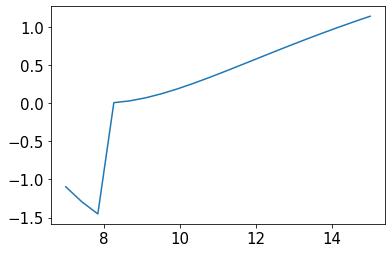

In [8]:
plt.plot(Us,zetaL*3e-3)

(0.0, 0.5)

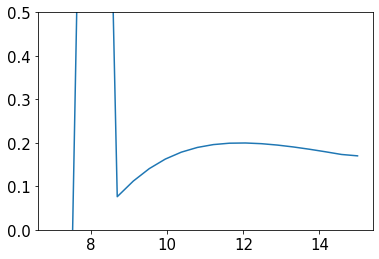

In [11]:
plt.plot(Us,np.gradient(zetaL,Us)*3e-3)
plt.ylim(0.,0.5)

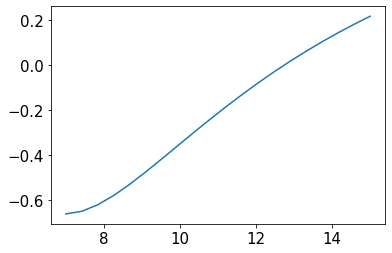

In [67]:
plt.plot(Us,cs)

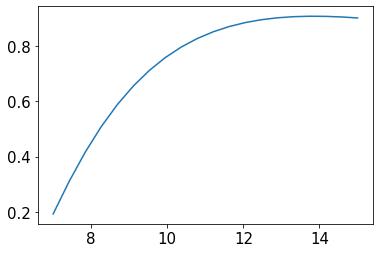

In [68]:
plt.plot(Us,ss)

# QL

## regressions

Text(0.5, 0.98, 'Winds regressed onto T_L')

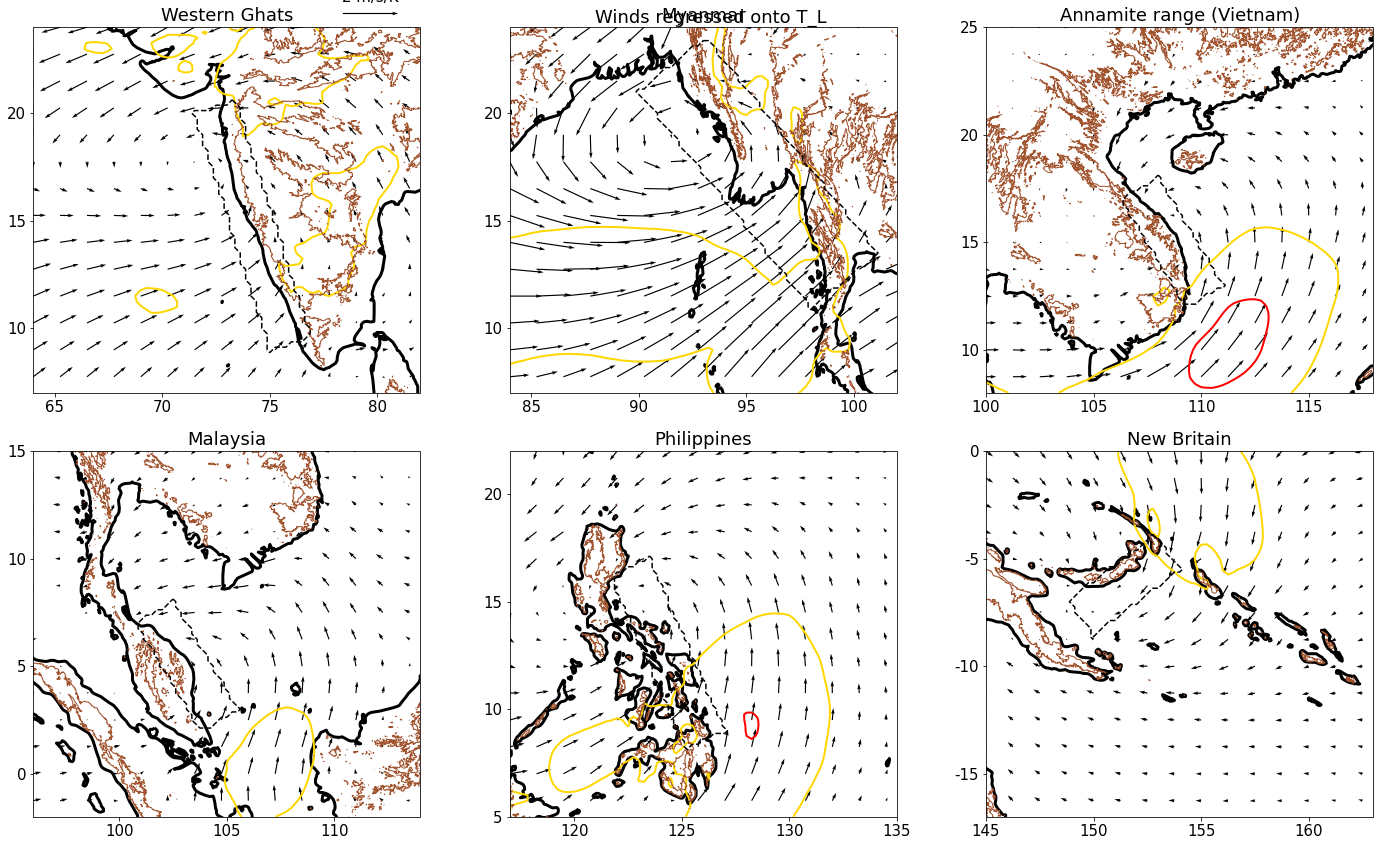

In [55]:
fig,axs = plt.subplots(2,3,figsize=(20,12),subplot_kw={"projection":ccrs.PlateCarree()})
axs=axs.reshape(-1)
levs = np.linspace(-60,60,21)
varname = 'UBL_DAILY'

for i,(ax,MR) in enumerate(zip(axs,MRs)):
    pred = MR.vars['QLSEMI_ABOVE_DAILY']*2.5e3
    u = MR.vars['UBL_DAILY'];v = MR.vars['VBL_DAILY']
    
    ureg = linregress_xr_2(pred,u)
    vreg = linregress_xr_2(pred,v)
    fdrfact = fdr_xr_2d(ureg.pvalue,0.1) + fdr_xr_2d(vreg.pvalue,0.1) >0
    u = ureg.slope /fdrfact;v=vreg.slope /fdrfact
    if i!=0:
        add_wind(ax,u,v,width=0.003,scale=14,key=False)
    else:
        add_wind(ax,u,v,width=0.003,scale=14,ref=2,pos=(0.87,1.04))
        

    np.maximum(ureg.rsquared,vreg.rsquared).plot.contour(ax=ax,levels=[0.2,0.4],linewidths=[2,2],colors=['gold','red'])
    sel_box(topo_hires,MR.box).plot.contour(ax=ax,transform=ccrs.PlateCarree(),levels=[500.],linewidths=[1],colors=['sienna'])
    
    tilted_rect(ureg,*MR.box_tilted).plot.contour(ax=ax,levels=[0.5],linestyles=['--'],colors=['k'])

    ax.coastlines(linewidth=3)
    ax.set_title(MR.Lname)
    add_latlon(ax,MR.box)

fig.tight_layout()
plt.suptitle('Winds regressed onto T_L')

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


Text(0.5, 0.98, 'Winds regressed onto T_L')

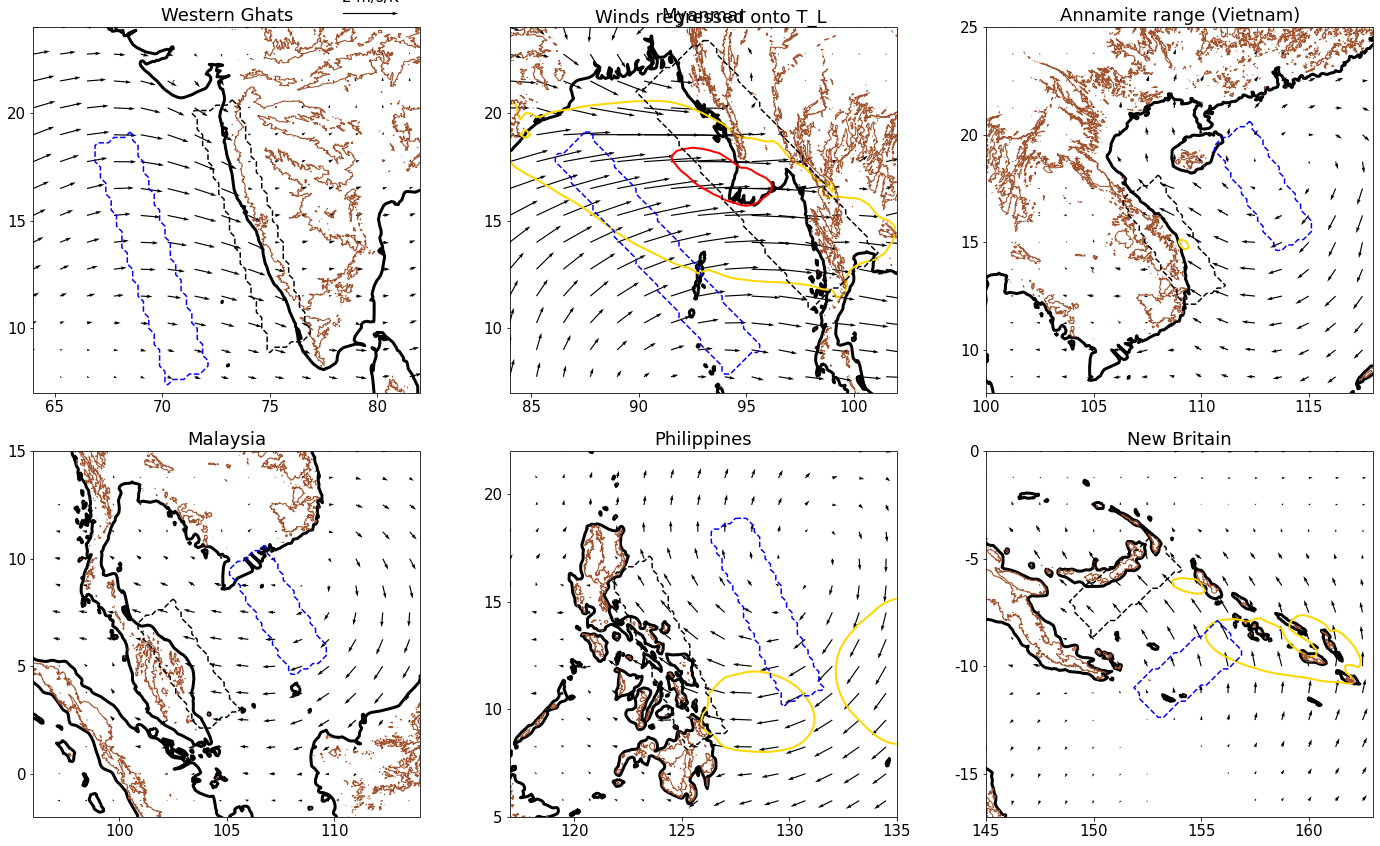

In [50]:
fig,axs = plt.subplots(2,3,figsize=(20,12),subplot_kw={"projection":ccrs.PlateCarree()})
axs=axs.reshape(-1)
levs = np.linspace(-60,60,21)
varname = 'UBL_DAILY'

for i,(ax,MR) in enumerate(zip(axs,MRs)):
    mask_ups = tilted_rect_distance(MR.vars['QLSEMI_DAILY'],*MR.box_tilted[:-1],-3,-5)
    pred = (MR.vars['QLSEMI_ABOVE_DAILY']-spatial_mean(MR.vars['QLSEMI_DAILY'],mask=mask_ups))*2.5e3
    u = MR.vars['UBL_DAILY'];v = MR.vars['VBL_DAILY']
    
    ureg = linregress_xr_2(pred,u)
    vreg = linregress_xr_2(pred,v)
    fdrfact = fdr_xr_2d(ureg.pvalue,0.1) + fdr_xr_2d(vreg.pvalue,0.1) >0
    u = ureg.slope /fdrfact;v=vreg.slope /fdrfact
    if i!=0:
        add_wind(ax,u,v,width=0.003,scale=14,key=False)
    else:
        add_wind(ax,u,v,width=0.003,scale=14,ref=2,pos=(0.87,1.04))
        

    np.maximum(ureg.rsquared,vreg.rsquared).plot.contour(ax=ax,levels=[0.2,0.4],linewidths=[2,2],colors=['gold','red'])
    sel_box(topo_hires,MR.box).plot.contour(ax=ax,transform=ccrs.PlateCarree(),levels=[500.],linewidths=[1],colors=['sienna'])
    
    tilted_rect(ureg,*MR.box_tilted).plot.contour(ax=ax,levels=[0.5],linestyles=['--'],colors=['k'])
    mask_ups.plot.contour(ax=ax,levels=[0.5],linestyles=['--'],colors=['b'])

    ax.coastlines(linewidth=3)
    ax.set_title(MR.Lname)
    add_latlon(ax,MR.box)

fig.tight_layout()
plt.suptitle('Winds regressed onto T_L')

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


Text(0.5, 0.98, 'Winds regressed onto T_L')

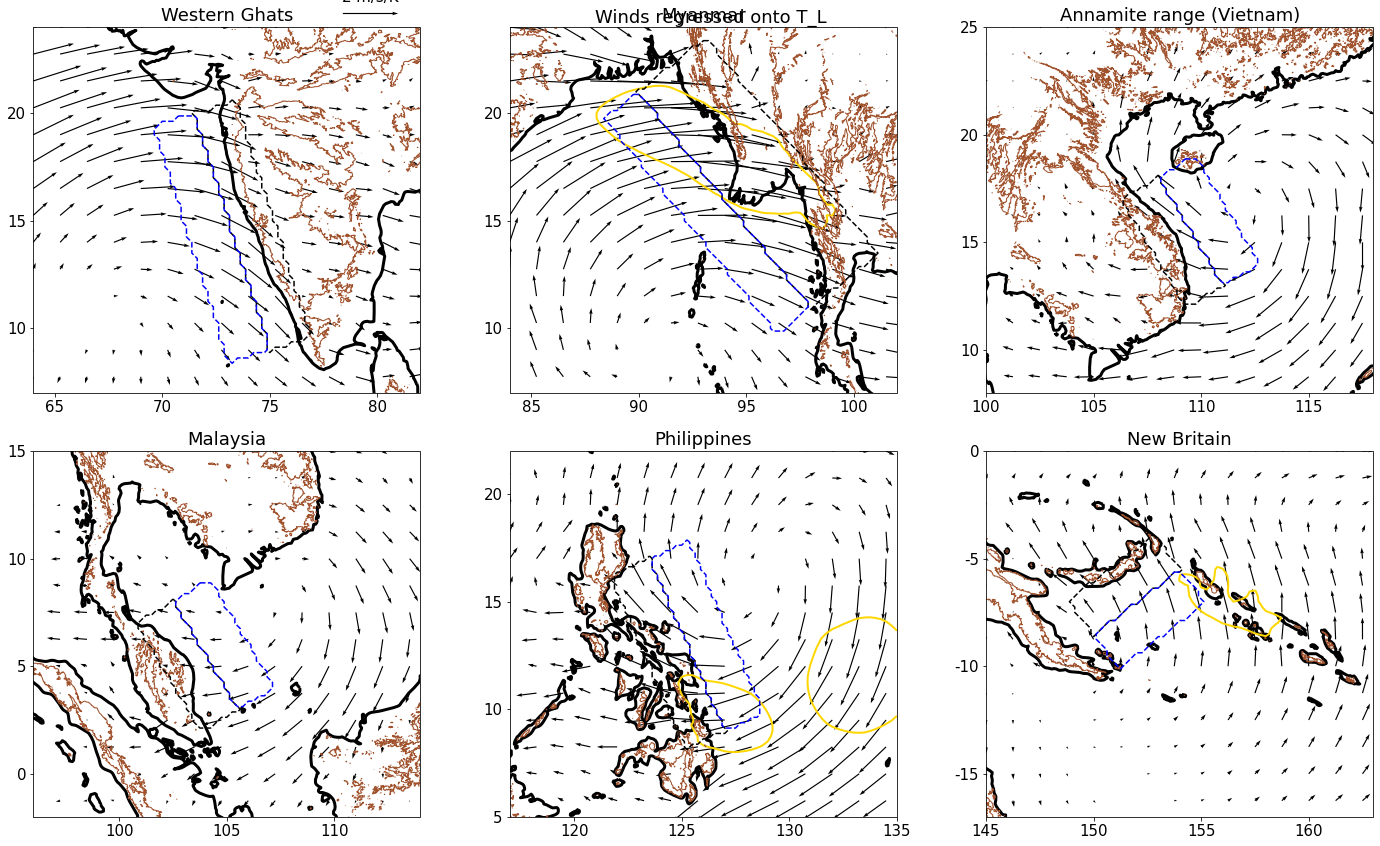

In [119]:
fig,axs = plt.subplots(2,3,figsize=(20,12),subplot_kw={"projection":ccrs.PlateCarree()})
axs=axs.reshape(-1)
levs = np.linspace(-60,60,21)
varname = 'UBL_DAILY'

for i,(ax,MR) in enumerate(zip(axs,MRs)):
    mask_ups = tilted_rect_distance(MR.vars['QLSEMI_DAILY'],*MR.box_tilted[:-1],0,-2)
    pred = (MR.vars['QLSEMI_ABOVE_DAILY']-spatial_mean(MR.vars['QLSEMI_DAILY'],mask=mask_ups))*2.5e3
    u = MR.vars['UBL_DAILY'];v = MR.vars['VBL_DAILY']
    
    ureg = linregress_xr_2(pred,u)
    vreg = linregress_xr_2(pred,v)
    fdrfact = fdr_xr_2d(ureg.pvalue,0.1) + fdr_xr_2d(vreg.pvalue,0.1) >0
    u = ureg.slope /fdrfact;v=vreg.slope /fdrfact
    if i!=0:
        add_wind(ax,u,v,width=0.003,scale=14,key=False)
    else:
        add_wind(ax,u,v,width=0.003,scale=14,ref=2,pos=(0.87,1.04))
        

    np.maximum(ureg.rsquared,vreg.rsquared).plot.contour(ax=ax,levels=[0.2,0.4],linewidths=[2,2],colors=['gold','red'])
    sel_box(topo_hires,MR.box).plot.contour(ax=ax,transform=ccrs.PlateCarree(),levels=[500.],linewidths=[1],colors=['sienna'])
    
    tilted_rect(ureg,*MR.box_tilted).plot.contour(ax=ax,levels=[0.5],linestyles=['--'],colors=['k'])
    mask_ups.plot.contour(ax=ax,levels=[0.5],linestyles=['--'],colors=['b'])

    ax.coastlines(linewidth=3)
    ax.set_title(MR.Lname)
    add_latlon(ax,MR.box)

fig.tight_layout()
plt.suptitle('Winds regressed onto T_L')

In [64]:
# Stability
Newbritain.set_3dvar('PHI',"128_129_z")
sample_geopotential = Newbritain.vars['PHI'].mean(['latitude','longitude'])/9.81
dzdp = sample_geopotential.differentiate('level')

for MR in MRs:
    q_daily = xr.open_dataarray("/global/cscratch1/sd/qnicolas/regionsDataBig/e5.oper.an.pl.128_133_q.ll025sc.2001-2020.{}.{}.nc".format(MR._monthstr,MR.name))
    mask_ups = tilted_rect(q_daily,*MR.box_tilted,reverse=True)
    MR.vars['Q_UPSTREAM_PROFILE'] = spatial_mean(q_daily.mean('time'),mask=mask_ups)*2.5e3
    dqdp = MR.vars['Q_UPSTREAM_PROFILE'].differentiate('level')
    dqdz_K = dqdp/dzdp
    dqdz_K = dqdz_K.sel(level=slice(700,900)).mean('level')
    MR.vars['DQDZ_UPSTREAM_PROFILE'] = dqdz_K
    #t_daily = xr.open_dataarray("/global/cscratch1/sd/qnicolas/regionsDataBig/e5.oper.an.pl.128_130_t.ll025sc.2001-2020.{}.{}.nc".format(MR._monthstr,MR.name))
    #dTdp = t_daily.differentiate('level')
    #dsdz = dTdp/dzdp + 9.81/1004.
    #dsdz = dsdz.sel(level=slice(600,900)).mean('level')
    #MR.vars['DSDZ_DAILY'] = dsdz.load()

In [65]:
for MR in MRs:
    print(MR.name,MR.vars['DQDZ_UPSTREAM_PROFILE']*1e3)

ghats <xarray.DataArray ()>
array(-8.43190487)
myanmar <xarray.DataArray ()>
array(-8.10841938)
vietnam <xarray.DataArray ()>
array(-8.05302124)
malaysia <xarray.DataArray ()>
array(-7.15642691)
philippines <xarray.DataArray ()>
array(-8.97430091)
newbritain <xarray.DataArray ()>
array(-7.67114587)


In [55]:
mask_ups = tilted_rect_distance(MR.vars['QLSEMI_DAILY'],*MR.box_tilted[:-1],-3,-5)
meanprof = spatial_mean(testq.mean('time'),mask=mask_ups)*2.5e3

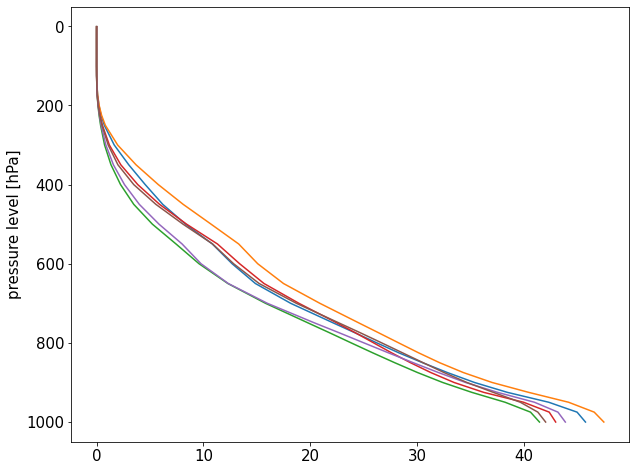

In [63]:
plt.figure(figsize=(10,8))
for MR in MRs:
    MR.vars['Q_UPSTREAM_PROFILE'].plot(y='level',yincrease=False)

## Mean qL maps

Text(0.5, 1.0, 'q avg over full depth of troposphere')

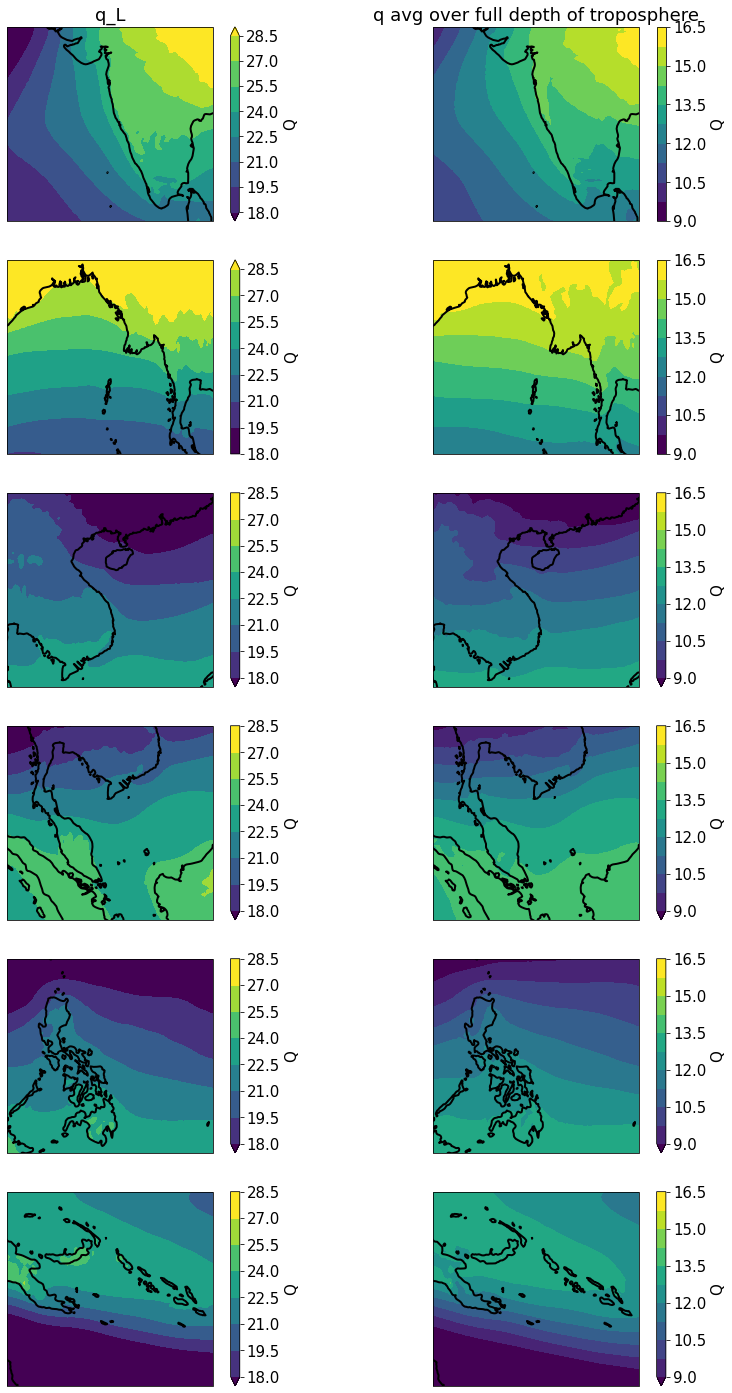

In [134]:
fig,axss = plt.subplots(6,2,figsize=(14,25),subplot_kw={"projection":ccrs.PlateCarree()})
for axs,MR in zip(axss,MRs):
    lvls = np.arange(18,30,1.5)
    (2.5e3*MR.vars['QLSEMI_DAILY'].mean('time')).plot.contourf(ax=axs[0],levels=lvls,transform=ccrs.PlateCarree())
    lvls = np.arange(9,17,0.75)
    (2.5e3/1000*MR.vars['Q_VINTEG_DAILY'].mean('time')).plot.contourf(ax=axs[1],levels=lvls,transform=ccrs.PlateCarree())
    for ax in axs:
        ax.coastlines(linewidth=2)
axss[0,0].set_title("q_L")
axss[0,1].set_title("q avg over full depth of troposphere")

In [ ]:
# u.grad q



## d(qL)/dU in our linear model

In [75]:
from orographicConvectionTheory.orographicConvectionTheory import *

In [97]:
def linear_qdL(xx,hx,U):
    cp = 1004. #Heat capacity of air in J/kg/K

    z=np.arange(0,10000,100)
    k=k_vector(len(xx),xx[1]-xx[0])

    zbot=1000
    ztop=4000
    z_slice = z[np.where((z>=zbot) & (z<=ztop))]

    ds0dz,dq0dz,N = lapse_rates()

    qdhat = -dq0dz*np.fft.fft(hx)*np.exp( m_exponent(k[:,None],N,U)  *  z_slice[None,:]).mean(axis=1)

    return np.real(np.fft.ifft(qdhat))/cp#

def linear_qL(xx,hx,U,tauT=3,tauq=11,switch=1):
    pT_ov_g = 8e3 #mass of troposphere in kg/m2
    
    z=np.arange(0,10000,100)
    k=k_vector(len(xx),xx[1]-xx[0])
    
    tauT*=3600
    tauq*=3600
    
    Lq=compute_Lq(5,U,tauq)
    
    ds0dz,dq0dz,N = lapse_rates()
    chi = (ds0dz/tauT - dq0dz/tauq)
    
    zbot=1000
    ztop=4000    
    z_slice = z[np.where((z>=zbot) & (z<=ztop))]
    Pprimehat = 1j*k/(1j*k + switch*1/Lq) * chi * np.fft.fft(hx) * np.exp( m_exponent(k[:,None],N,U)  *  z_slice[None,:]).mean(axis=1) 
    Pprime = np.real(np.fft.ifft(Pprimehat))
    
    Tdhat = ds0dz*np.fft.fft(hx)*np.exp( m_exponent(k[:,None],N,U)  *  z_slice[None,:]).mean(axis=1)
    Td = np.real(np.fft.ifft(Tdhat))
    
    return (Pprime - Td/tauT)*tauq/cp


(-1000.0, 1000.0)

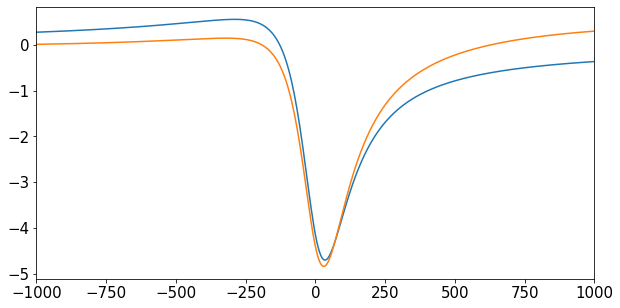

In [98]:
xx,hx = topographic_profile('agnesi')
qd = linear_qdL(xx,hx,10)
qL = linear_qL(xx,hx,10,7.5,27.5)
plt.figure(figsize=(10,5))
plt.plot(xx/1e3,qd)
plt.plot(xx/1e3,qL)
plt.xlim(-1000,1000)

In [104]:
(xx/1000)[1940]

-300.0

In [105]:
Us = np.linspace(7,15,20)
qLs = [linear_qdL(xx,hx,u)[1940] for u in Us]

(0.0, 0.6)

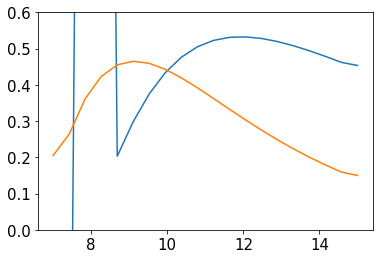

In [106]:
plt.plot(Us,np.gradient(zetaL,Us)*8e-3)
plt.plot(Us,np.gradient(qLs,Us))

plt.ylim(0.,0.6)

In [112]:
Us = np.linspace(7,15,20)
qdLs = [np.max(linear_qdL(xx,hx,u)[:2000]) for u in Us]
qLs = [np.max(linear_qL(xx,hx,u)[:2000]) for u in Us]

(0.0, 0.6)

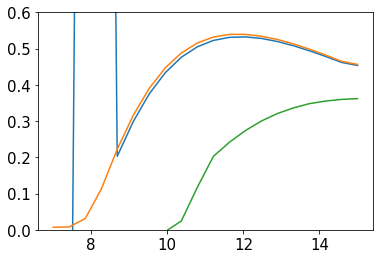

In [113]:
plt.plot(Us,np.gradient(zetaL,Us)*8e-3)
plt.plot(Us,np.gradient(qdLs,Us))
plt.plot(Us,np.gradient(qLs,Us))

plt.ylim(0.,0.6)